In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.transform import resize


In [2]:
import numpy as np

In [3]:
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch as torch
import torch.nn as nn


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Define Model

In [5]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 1500)  # input -> first hidden layer
        
        self.hidden_next = nn.Linear(1500, 100) # first hidden -> second hidden layer
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(100, 10)  # second hidden -> output layer
         
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1) # apply softmax to logits

        
    def forward(self, x):
        x = self.hidden(x)
        x = self.hidden_next(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)     
        return x

In [6]:
transform=transforms.Compose([
        transforms.ToTensor(),
        ])

In [7]:
mnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [8]:
model = Net()

for i in range(0, 1):
    model.eval()
    img = mnist_trainset[i][0]
    img = img.view(-1,img.shape[0] )
    img = img.transpose(0, 1)
    output = model(img)
    print(output)
    print(mnist_trainset[i][1])

tensor([[0.0742, 0.0558, 0.0626, 0.0930, 0.1004, 0.0776, 0.1106, 0.1788, 0.1056,
         0.1414]], grad_fn=<SoftmaxBackward>)
9


Training Process

In [9]:
# def cross_entropy_one_hot(inputs, target):
#     _, labels = target.max(dim=1)
#     return nn.CrossEntropyLoss()(inputs, labels)

def compute_accuracy(inputs, target):
    # _, labels = target.max(dim=1)
    # print(inputs)
    return (torch.sum(target==torch.argmax(inputs, dim=1)))

In [10]:

from torch import optim 
# helper function to train a model
def train_model():
    criterion = nn.CrossEntropyLoss()
    model = Net()
    # model.apply(weights_init_uniform) # change weight initialization herer
    model = model.to(device)
    bs = 20 # batch size
    trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=bs, shuffle=False,)
    #define loss function
    #define learning rate
    learning_rate = 0.001 # change learning rate here
    #define number of epochs
    epochs = 4
    #initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #run training and print out the loss to make sure that we are actually fitting to the training set
    print('Training the model. Make sure that loss decreases after each epoch.\n')
    prev_loss = 0
    cumulative_acc = 0
    total_train = 0
    for e in range(epochs):
        model.train()
        cumulative_acc = 0
        total_train = 0
        if(e != 0):
            model.load_state_dict(torch.load('nn_params.pth'))
        running_loss = 0
        for images, labels in trainloader:
            total_train += bs
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(images.shape[0], -1)  
            log_ps = model(images)
            optimizer.zero_grad()
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            cumulative_acc += compute_accuracy(log_ps, labels)
            running_loss += loss.item()
        if(e == 0):
            prev_loss = running_loss
        if(running_loss <= prev_loss):
            torch.save(model.state_dict(), 'nn_params.pth')
            prev_loss = running_loss
        print(f"Accuracy: {cumulative_acc/total_train}")
        print(f"Training loss: {running_loss}")

In [11]:
train_model()

Training the model. Make sure that loss decreases after each epoch.

Accuracy: 0.7805833220481873
Training loss: 5087.933377623558
Accuracy: 0.8259166479110718
Training loss: 4925.689659118652
Accuracy: 0.8296000361442566
Training loss: 4910.027336597443
Accuracy: 0.831250011920929
Training loss: 4906.411588549614


In [12]:
mnist_valset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(mnist_valset,
                                          batch_size=1,
                                          shuffle=False,)


In [13]:
num_correct = 0
count = 0
model.load_state_dict(torch.load('nn_params.pth'))
for img, label in val_loader:
    count += 1
    model.eval()
    model = model.to(device)
    img = img.to(device)
    img = img.view(img.shape[0], -1)
    output = model(img)
    pred = torch.argmax(output, dim=1)
    if pred.item() == label.item():
        num_correct += 1
acc = num_correct/count

In [14]:
def fashionLabelToClass(label):
  labeller = {
      0: "Top",  
      1: "Trouser",  
      2: "Pullover",  
      3: "Dress",  
      4: "Coat",  
      5: "Sandal",  
      6: "Shirt",  
      7: "Sneaker",  
      8: "Bag",  
      9: "Ankle Boot"
  }
  return labeller.get(label, "Invalid Class")

Prediction for this image is Trouser


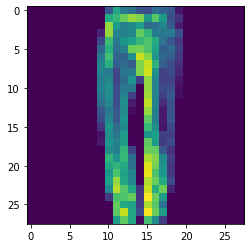

In [15]:
img = mnist_valset[350][0]
label = mnist_valset[350][1]
img_disp = img.reshape([28, 28])
model.eval()
model = model.to(device)
img = img.to(device)
img = img.view(img.shape[0], -1)
output = model(img)
pred = torch.argmax(output, dim=1)
plt.imshow(img_disp)
print("Prediction for this image is %s" % fashionLabelToClass(pred.item()))

In [16]:
img_classifier = model
img_classifier.to(device)

Net(
  (hidden): Linear(in_features=784, out_features=1500, bias=True)
  (hidden_next): Linear(in_features=1500, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

####**RISE**

In [17]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

In [18]:


def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array((28 ,28)) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N,*(28, 28)))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + 28, y:y + 28]
    masks = masks.reshape(-1, *(28, 28), 1)
    return masks

In [19]:
batch_size = 100

def explain(model, inp, masks):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        masked = torch.tensor(masked).float()
        masked = masked.to(device)
        preds.append(img_classifier(masked[i:min(i+batch_size, N)]).cpu().detach().numpy())
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *(28, 28))
    sal = sal / N / p1
    return sal

In [20]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [21]:
N = 500
s = 8
p1 = 0.5
masks = generate_masks(500, 8, 0.5)

Generating masks: 100%|██████████| 500/500 [00:00<00:00, 868.19it/s]


2


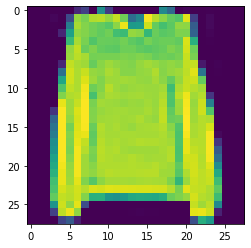

In [28]:
img = mnist_valset[361][0]
label = mnist_valset[361][1]
print(label)
img_disp = img.reshape([28, 28])
plt.imshow(img_disp)

In [29]:
x = img.view(img.shape[0], -1)
x = x.cpu().detach().numpy()
# x = x.to(device)
img = img_disp
img = img.to(device)

In [30]:
sal = explain(img_classifier, x, masks)

Explaining:  20%|██        | 1/5 [00:02<00:09,  2.46s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
Explaining: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


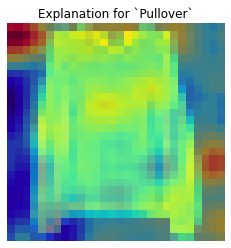

In [33]:
class_idx = 2
plt.title('Explanation for `{}`'.format(fashionLabelToClass(mnist_valset[361][1])))
plt.axis('off')
plt.imshow(img_disp)
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()